<a href="https://colab.research.google.com/github/VYyudi/Programa-Trainee-triggo.ai-de-Excel-ncia-em-Engenharia-de-Dados-e-DataOps/blob/main/Triggo_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio Técnico - triggo.ai | Engenharia de Dados e DataOps 2025



#  ETAPA 1 – Preparação dos Dados (25 pontos)
# 1.1. Importe as bibliotecas necessárias

In [ ]:
import pandas as pd
import duckdb
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import seaborn as sns
import plotly.express as px
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# 1.2. Importe os dados do Kaggle

In [ ]:
import kagglehub

path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brazilian-ecommerce


# 1.3. Leia os arquivos CSV

In [ ]:
orders = pd.read_csv(f"{path}/olist_orders_dataset.csv")
customers = pd.read_csv(f"{path}/olist_customers_dataset.csv")
order_items = pd.read_csv(f"{path}/olist_order_items_dataset.csv")
products = pd.read_csv(f"{path}/olist_products_dataset.csv")
sellers = pd.read_csv(f"{path}/olist_sellers_dataset.csv")
order_reviews = pd.read_csv(f"{path}/olist_order_reviews_dataset.csv")
geolocation = pd.read_csv(f"{path}/olist_geolocation_dataset.csv")
payments = pd.read_csv(f"{path}/olist_order_payments_dataset.csv")

# 1.4. Trate os dados

In [ ]:
orders.dropna(inplace=True)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

customers.dropna(inplace=True)

order_items.dropna(inplace=True)
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'])

products.dropna(inplace=True)

sellers.dropna(inplace=True)

order_reviews.dropna(inplace=True)
order_reviews['review_creation_date'] = pd.to_datetime(order_reviews['review_creation_date'])
order_reviews['review_answer_timestamp'] = pd.to_datetime(order_reviews['review_answer_timestamp'])

geolocation.dropna(inplace=True)

payments.dropna(inplace=True)

# 1.5. Crie um banco SQLite e relacione as tabelas

In [ ]:
conn = sqlite3.connect(":memory:")
orders.to_sql("orders", conn, index=False, if_exists="replace")
customers.to_sql("customers", conn, index=False, if_exists="replace")
order_items.to_sql("order_items", conn, index=False, if_exists="replace")
sellers.to_sql("sellers", conn, index=False, if_exists="replace")
order_reviews.to_sql("order_reviews", conn, index=False, if_exists="replace")
geolocation.to_sql("geolocation", conn, index=False, if_exists="replace")
payments.to_sql("payments", conn, index=False, if_exists="replace")
products.to_sql("products", conn, index=False, if_exists="replace")


32340

# ETAPA 2 – Análise Exploratória (25 pontos)
# a) Volume de pedidos por mês

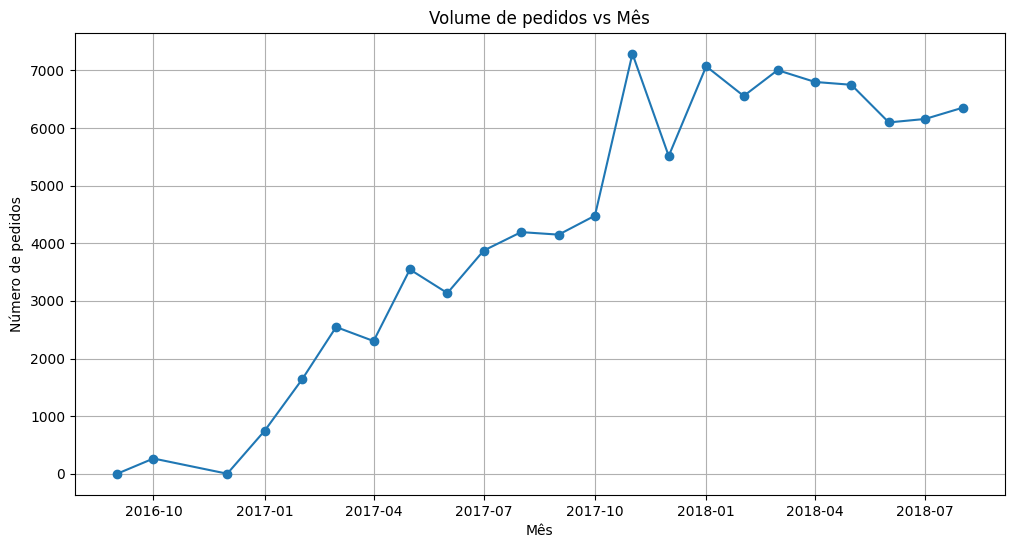

In [ ]:
# Consulta SQL
query = """
SELECT
  strftime('%Y-%m', order_purchase_timestamp) AS order_month,
  COUNT(*) AS num_orders
FROM orders
WHERE order_status = 'delivered'
GROUP BY order_month
ORDER BY order_month
"""

# Executar a consulta
monthly_orders = pd.read_sql_query(query, conn)

# Converter para datetime para plotar corretamente
monthly_orders['order_month'] = pd.to_datetime(monthly_orders['order_month'])

# Plotar gráfico
plt.figure(figsize=(12,6))
plt.plot(monthly_orders['order_month'], monthly_orders['num_orders'], marker='o')
plt.title('Volume de pedidos vs Mês')
plt.xlabel('Mês')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.show()

# b) Distribuição do tempo de entrega



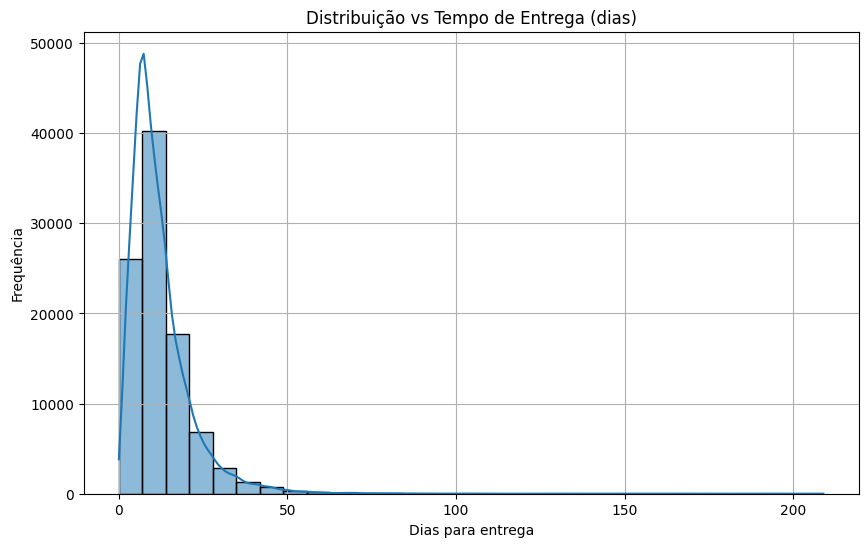

In [ ]:
# Consulta SQL
query = """
SELECT
  CAST(julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) AS INTEGER) AS delivery_time_days
FROM orders
WHERE order_status = 'delivered'
  AND order_delivered_customer_date IS NOT NULL
  AND order_purchase_timestamp IS NOT NULL;
"""

# Executar a consulta
delivery_df = pd.read_sql_query(query, conn)

# Plotar histograma com Seaborn
plt.figure(figsize=(10,6))
sns.histplot(delivery_df['delivery_time_days'], bins=30, kde=True)
plt.title("Distribuição vs Tempo de Entrega (dias)")
plt.xlabel("Dias para entrega")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

#c) Qual a relação entre o valor do frete e a distância de entrega?


In [ ]:
# Média de lat/lng por CEP
geo = geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()

# Adiciona prefixo numérico dos CEPs
customers['zip_prefix'] = customers['customer_zip_code_prefix']
sellers['zip_prefix'] = sellers['seller_zip_code_prefix']

# Junta latitude e longitude nos clientes e vendedores
customers_geo = customers.merge(geo, left_on='zip_prefix', right_on='geolocation_zip_code_prefix', how='left')
sellers_geo = sellers.merge(geo, left_on='zip_prefix', right_on='geolocation_zip_code_prefix', how='left')

# Une pedidos com seus itens
items_orders = order_items.merge(orders, on='order_id', how='left')

# Junta com info do cliente
items_orders = items_orders.merge(customers_geo, on='customer_id', how='left', suffixes=('', '_customer'))

# Junta com info do vendedor
items_orders = items_orders.merge(sellers_geo, on='seller_id', how='left', suffixes=('', '_seller'))

In [ ]:
def calc_distance(row):
    try:
        client_coords = (row['geolocation_lat'], row['geolocation_lng'])
        seller_coords = (row['geolocation_lat_seller'], row['geolocation_lng_seller'])
        if np.nan in client_coords or np.nan in seller_coords:
            return np.nan
        return geodesic(client_coords, seller_coords).km
    except:
        return np.nan

items_orders['distance_km'] = items_orders.apply(calc_distance, axis=1)

NameError: name 'pd' is not defined

In [ ]:
# Filtro para manter apenas linhas válidas
df_plot = items_orders[['freight_value', 'distance_km']].dropna()

# Gráfico
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_plot, x='distance_km', y='freight_value', alpha=0.5)
plt.title("Valor do Frete vs Distância entre Cliente e Vendedor")
plt.xlabel("Distância (km)")
plt.ylabel("Valor do Frete (R$)")
plt.grid(True)
plt.show()

# d) Categorias mais vendidas em faturamento

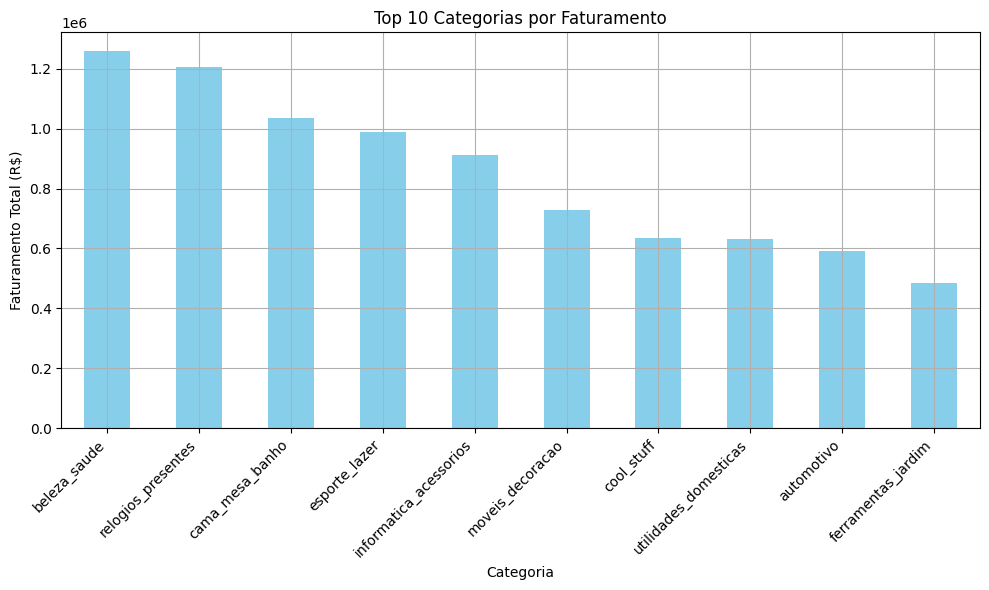

In [ ]:
query = """
SELECT
    p.product_category_name,
    SUM(oi.price) AS total_faturamento
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
GROUP BY p.product_category_name
ORDER BY total_faturamento DESC
LIMIT 10;
"""
df = pd.read_sql_query(query, conn)

# Gráfico
plt.figure(figsize=(10,6))
df.set_index('product_category_name')['total_faturamento'].plot(kind='bar', color='skyblue')
plt.title('Top 10 Categorias por Faturamento')
plt.xlabel('Categoria')
plt.ylabel('Faturamento Total (R$)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

# e) Estados com maior valor médio de pedido

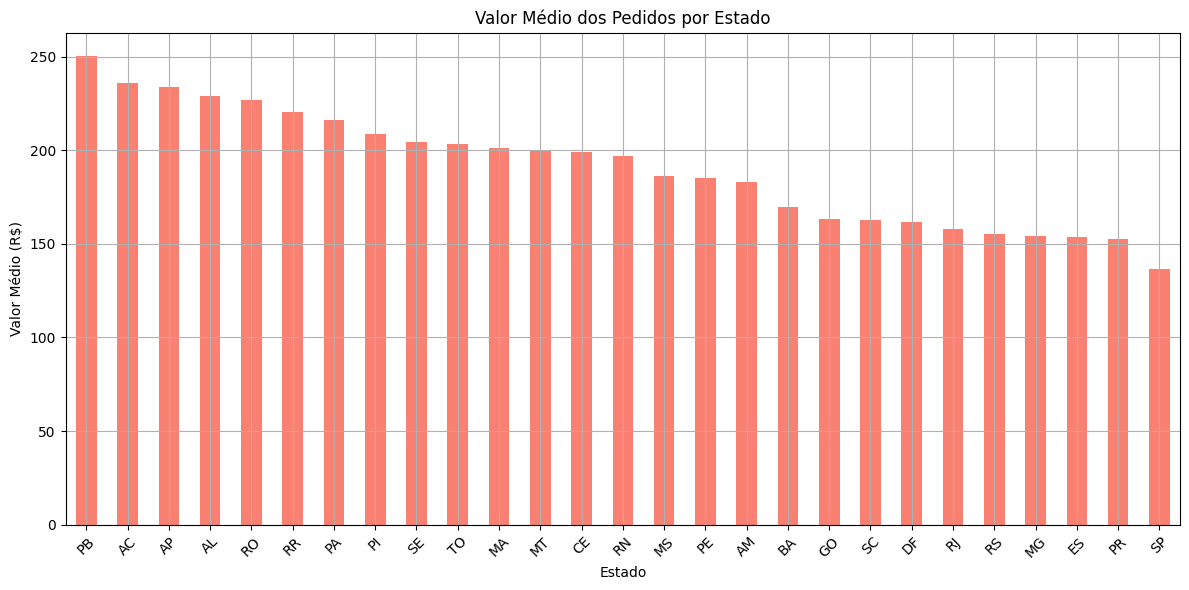

In [ ]:
query = """
SELECT
    c.customer_state,
    AVG(p.payment_value) AS valor_medio_pedido
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN payments p ON o.order_id = p.order_id
GROUP BY c.customer_state
ORDER BY valor_medio_pedido DESC;
"""
df = pd.read_sql_query(query, conn)

# Gráfico
plt.figure(figsize=(12,6))
df.set_index('customer_state')['valor_medio_pedido'].plot(kind='bar', color='salmon')
plt.title('Valor Médio dos Pedidos por Estado')
plt.xlabel('Estado')
plt.ylabel('Valor Médio (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()



# ETAPA 3 – Soluções de Negócio (25 pontos)
#  Retenção de Clientes

<20% a taxa e baixa

In [ ]:
# Contagem de pedidos por cliente
order_counts = orders.groupby('customer_id').size().reset_index(name='order_count')

# Marcar se é recorrente
order_counts['is_retained'] = order_counts['order_count'] > 1

# Calcular taxa de retenção
retained = order_counts[order_counts['is_retained']]
retention_rate = len(retained) / len(order_counts)

print(f"Taxa de clientes recorrentes: {retention_rate:.2%}")

print("\nTabela de Clientes Recorrentes (Top 10):")
print(retained.sort_values(by='order_count', ascending=False).head(10))

Taxa de clientes recorrentes: 0.00%

Tabela de Clientes Recorrentes (Top 10):
Empty DataFrame
Columns: [customer_id, order_count, is_retained]
Index: []


# Predição de Atraso
atraso como: entregue após order_estimated_delivery_date

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93     17728
           1       0.13      0.09      0.11      1565

    accuracy                           0.87     19293
   macro avg       0.52      0.52      0.52     19293
weighted avg       0.86      0.87      0.87     19293

Acurácia: 0.8741512465661121


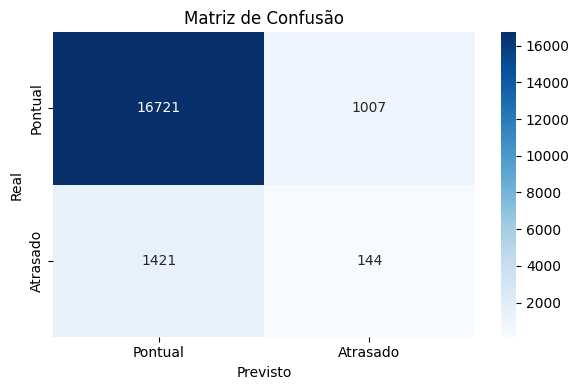

In [ ]:
# Criar coluna de atraso (1 se atrasado, 0 se não)
orders['is_late'] = (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']).astype(int)

# Remover registros com valores nulos
df = orders[['order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date',
             'order_delivered_customer_date', 'is_late']].dropna()

# Criar features
df['days_to_estimate'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days
df['days_to_approve'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600

X = df[['days_to_estimate', 'days_to_approve']]
y = df['is_late']

# Dividir em treino e teste (com estratificação)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))

# Matriz de confusão
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pontual', 'Atrasado'], yticklabels=['Pontual', 'Atrasado'])
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# Segmentação de Clientes

Grupo 0: clientes que compram pouco → campanha de incentivo

Grupo 1: clientes que compram muito, mas esporadicamente → programa de fidelidade

Grupo 2: clientes frequentes e de alto valor → VIP, ofertas exclusivas

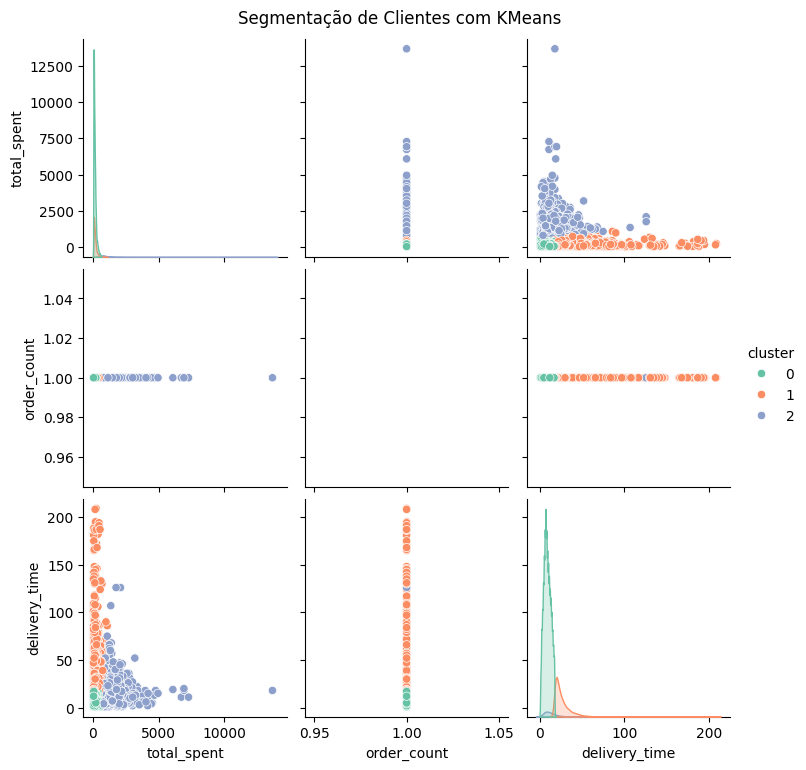

         total_spent  order_count  delivery_time
cluster                                         
0         126.919043          1.0       8.651307
1         151.047323          1.0      26.744670
2        1069.367376          1.0      13.110997


In [ ]:
# Calcular tempo de entrega
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Remover entregas com tempo negativo ou nulo
orders = orders[orders['delivery_time'] > 0]

# Unir payments com orders para obter customer_id
payments_orders = pd.merge(payments, orders[['order_id', 'customer_id']], on='order_id', how='left')
payments_orders['payment_value'] = pd.to_numeric(payments_orders['payment_value'], errors='coerce')
payments_orders = payments_orders.dropna(subset=['customer_id', 'payment_value'])

# Total gasto por cliente
payments_grouped = payments_orders.groupby('customer_id')['payment_value'].sum().reset_index()
payments_grouped.columns = ['customer_id', 'total_spent']

# Frequência de pedidos por cliente
order_freq = orders.groupby('customer_id').size().reset_index(name='order_count')

# Tempo médio de entrega
delivery_avg = orders.groupby('customer_id')['delivery_time'].mean().reset_index()

# Junta tudo
df_customers = payments_grouped.merge(order_freq, on='customer_id')
df_customers = df_customers.merge(delivery_avg, on='customer_id')
df_customers = df_customers.dropna()
df_customers[['total_spent', 'order_count', 'delivery_time']] = df_customers[['total_spent', 'order_count', 'delivery_time']].astype(float)

# Clustering
scaler = StandardScaler()
scaled = scaler.fit_transform(df_customers[['total_spent', 'order_count', 'delivery_time']])

kmeans = KMeans(n_clusters=3, random_state=42)
df_customers['cluster'] = kmeans.fit_predict(scaled)

# Visualização
sns.pairplot(df_customers, hue='cluster', diag_kind='kde', palette='Set2')
plt.suptitle("Segmentação de Clientes com KMeans", y=1.02)
plt.show()

cluster_summary = df_customers.groupby('cluster')[['total_spent', 'order_count', 'delivery_time']].mean()
print(cluster_summary)

#  Análise de Satisfação

In [ ]:
# Criar coluna de tempo de entrega
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Calcular o valor total do pedido por order_id
order_total = order_items.groupby('order_id')['price'].sum().reset_index()
order_total.columns = ['order_id', 'total_price']

# Unir as tabelas necessárias
df = orders.merge(order_reviews, on='order_id')
df = df.merge(order_items[['order_id', 'product_id']], on='order_id')
df = df.merge(products[['product_id', 'product_category_name']], on='product_id')
df = df.merge(order_total, on='order_id')

# Verificar dados disponíveis
print(df[['review_score', 'product_category_name', 'delivery_time', 'total_price']].head())


   review_score product_category_name  delivery_time  total_price
0             4            perfumaria             13        118.7
1             5            perfumaria             13        132.4
2             5             papelaria              4         89.9
3             1                 bebes             12        130.4
4             1                 bebes             12        130.4


#  1. Relação entre nota e tempo de entrega

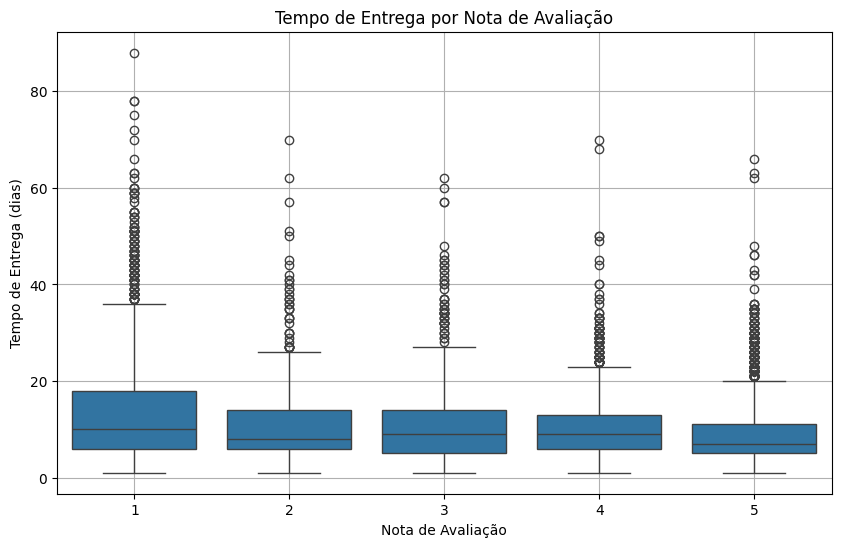

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='review_score', y='delivery_time')
plt.title("Tempo de Entrega por Nota de Avaliação")
plt.xlabel("Nota de Avaliação")
plt.ylabel("Tempo de Entrega (dias)")
plt.grid(True)
plt.show()

# 2. Relação entre nota e valor total do pedido

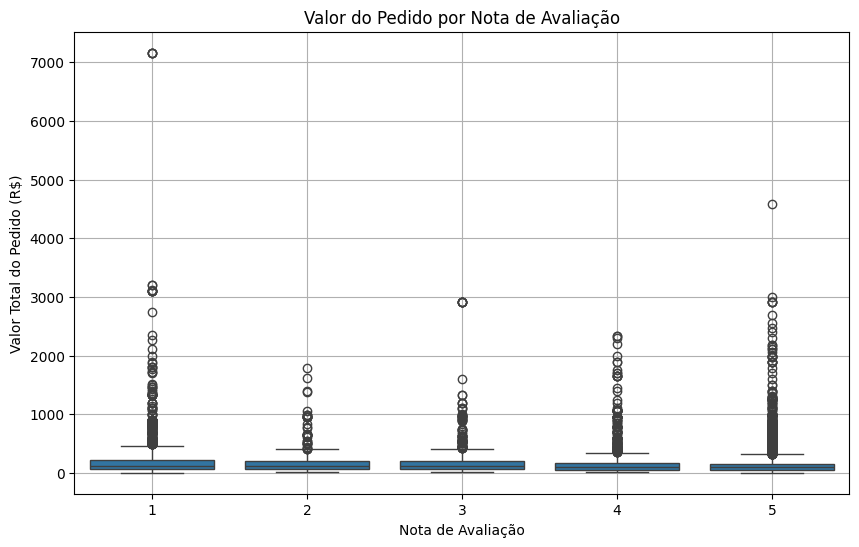

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='review_score', y='total_price', legend=False)
plt.title("Valor do Pedido por Nota de Avaliação")
plt.xlabel("Nota de Avaliação")
plt.ylabel("Valor Total do Pedido (R$)")
plt.grid(True)
plt.show()

# 3. Média da nota por categoria de produto (top 10)

<ipython-input-27-1f45b13a8e47>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x='product_category_name', y='review_score', palette='viridis')


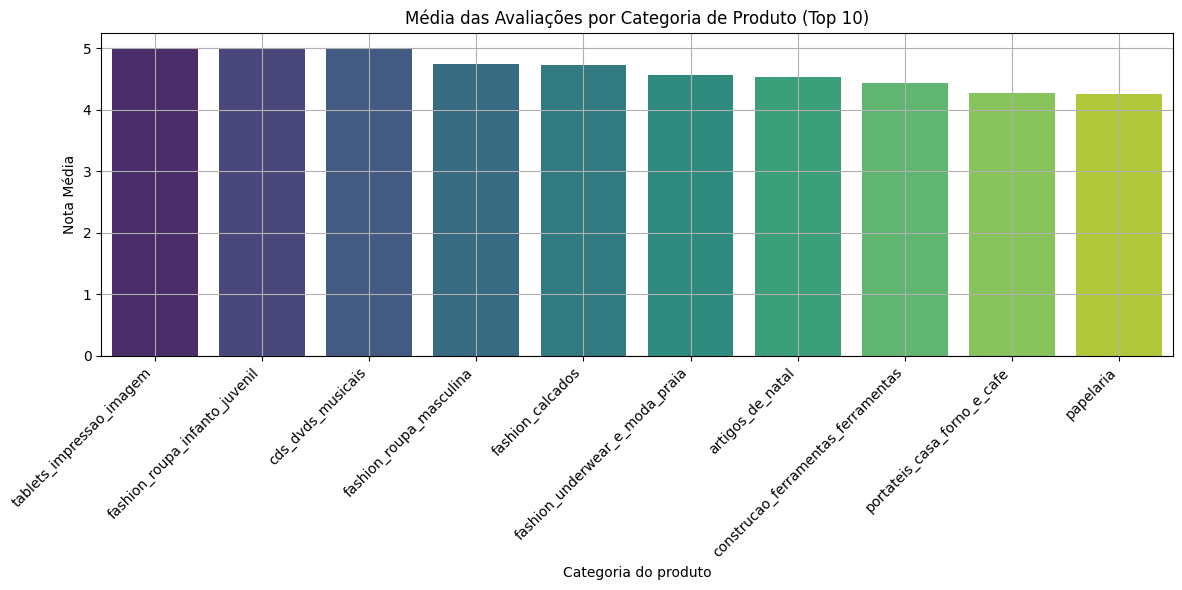

In [ ]:
top_categories = (
    df.groupby('product_category_name')['review_score']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()  # transforma em DataFrame
)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_categories, x='product_category_name', y='review_score', palette='viridis')
plt.title("Média das Avaliações por Categoria de Produto (Top 10)")
plt.ylabel("Nota Média")
plt.xlabel("Categoria do produto")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# ETAPA 4 - Visualização e Dashboards (25 pontos)

# Evolução de Vendas com Filtro por Estado e Categoria

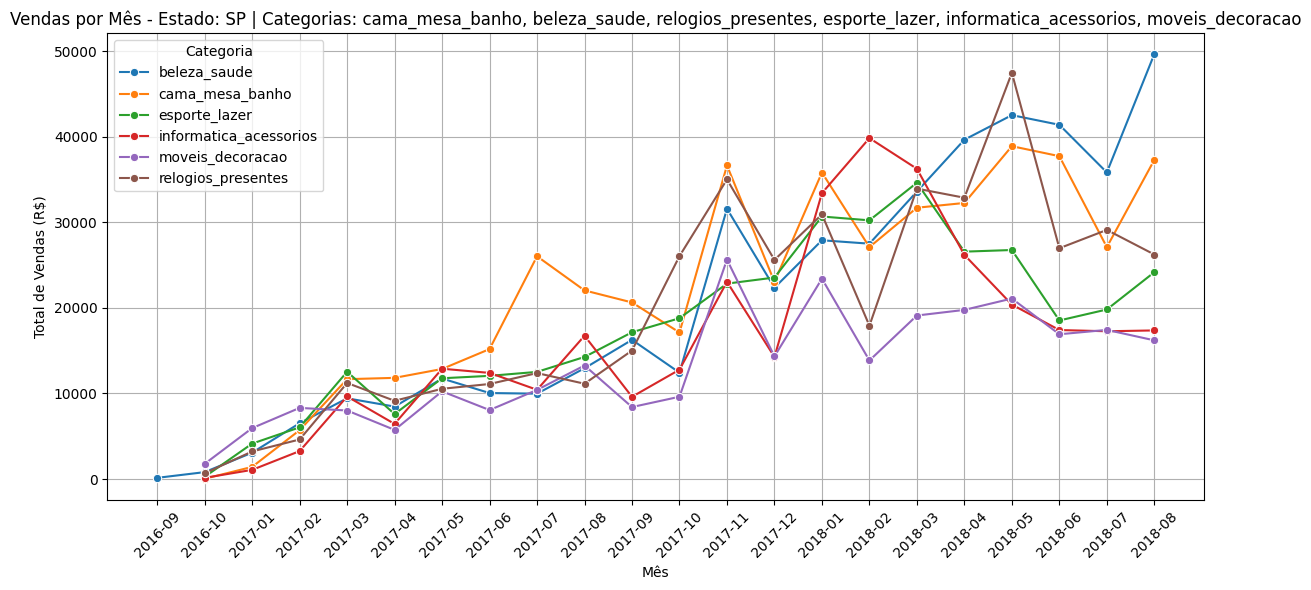

In [ ]:
# Mesclar dataframes
df_geral = orders.merge(order_items, on="order_id") \
                 .merge(customers, on="customer_id") \
                 .merge(products, on="product_id")

df_geral["order_purchase_timestamp"] = pd.to_datetime(df_geral["order_purchase_timestamp"])
df_geral["purchase_month"] = df_geral["order_purchase_timestamp"].dt.to_period("M").astype(str)

df_geral["estado_cliente"] = df_geral["customer_state"]
df_geral["categoria_produto"] = df_geral["product_category_name"]

# Estado filtrado
estado = "SP"

# Aqui filtra pelo top 6 categorias
# Se quiser todas as categorias tirar o head
top_categorias = (
    df_geral[df_geral["estado_cliente"] == estado]
    .groupby("categoria_produto")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(6)
    .index
    .tolist()
)

# Filtrar apenas o estado e as categorias selecionadas
df_filtrado = df_geral[
    (df_geral["estado_cliente"] == estado) &
    (df_geral["categoria_produto"].isin(top_categorias))
]

# Agrupar por mês, estado e categoria
vendas_estado_categoria = df_filtrado.groupby(
    ["purchase_month", "estado_cliente", "categoria_produto"]
).agg(total_vendas=("price", "sum")).reset_index()

# Plotar múltiplas linhas
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=vendas_estado_categoria,
    x="purchase_month",
    y="total_vendas",
    hue="categoria_produto", # Uma para cada categoria
    marker="o"
)
plt.title(f"Vendas por Mês - Estado: {estado} | Categorias: {', '.join(top_categorias)}")
plt.xticks(rotation=45)
plt.xlabel("Mês")
plt.ylabel("Total de Vendas (R$)")
plt.grid(True)
plt.legend(title="Categoria")
plt.tight_layout()
plt.show()

# Mapa de Calor: Vendas por Estado

<ipython-input-38-b3c67779d71f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vendas_estado, x="customer_state", y="total_vendas", palette="YlOrRd")


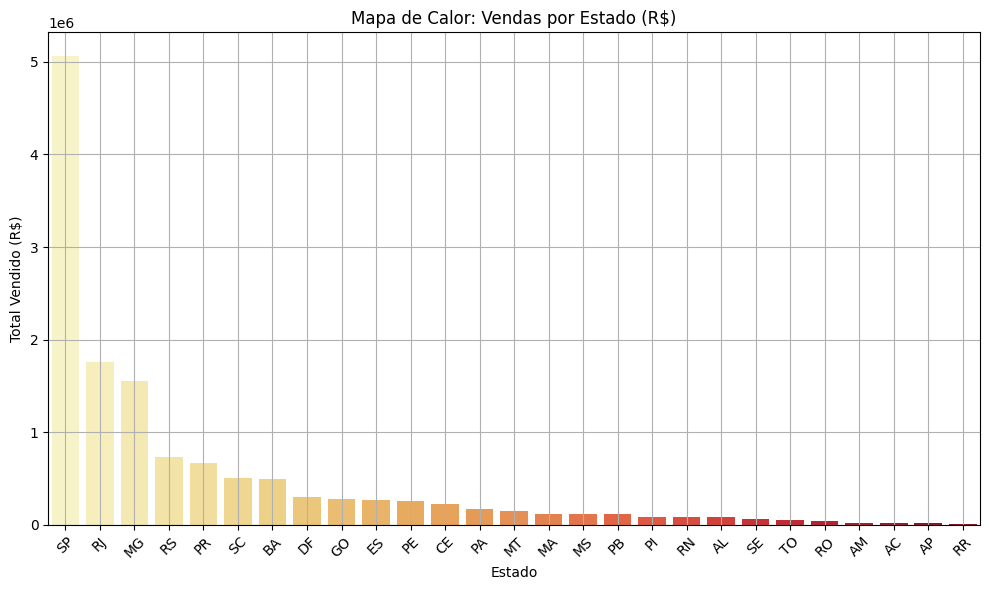

In [ ]:
# Merge dos dados para obter o estado e valor vendido
df_vendas = orders.merge(order_items, on="order_id") \
                  .merge(customers, on="customer_id")

# Agrupar por estado
vendas_estado = df_vendas.groupby("customer_state").agg(
    total_vendas=("price", "sum"),
    quantidade_pedidos=("order_id", "nunique")
).reset_index()

# Ordenar por total de vendas
vendas_estado = vendas_estado.sort_values("total_vendas", ascending=False)

# Plotar mapa de calor (heatmap)
plt.figure(figsize=(10, 6))
sns.barplot(data=vendas_estado, x="customer_state", y="total_vendas", palette="YlOrRd")
plt.title("Mapa de Calor: Vendas por Estado (R$)")
plt.xlabel("Estado")
plt.ylabel("Total Vendido (R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Gráfico: Avaliação do Cliente x Tempo de Entrega

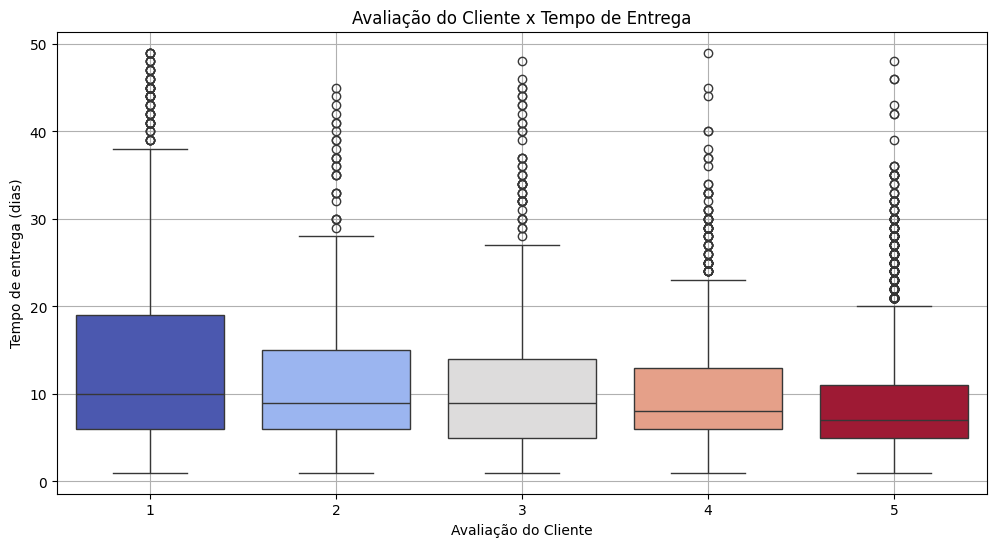

In [ ]:
# Unir pedidos com avaliações
df_avaliacoes = orders.merge(order_reviews, on="order_id")

# Converter datas
df_avaliacoes["order_delivered_customer_date"] = pd.to_datetime(df_avaliacoes["order_delivered_customer_date"])
df_avaliacoes["order_purchase_timestamp"] = pd.to_datetime(df_avaliacoes["order_purchase_timestamp"])

# Calcular tempo de entrega
df_avaliacoes["tempo_entrega_dias"] = (df_avaliacoes["order_delivered_customer_date"] - df_avaliacoes["order_purchase_timestamp"]).dt.days

# Filtrar valores extremos (entregas negativas ou muito demoradas)
df_avaliacoes_filtrado = df_avaliacoes[(df_avaliacoes["tempo_entrega_dias"] > 0) & (df_avaliacoes["tempo_entrega_dias"] < 50)]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_avaliacoes_filtrado,
    x="review_score",
    y="tempo_entrega_dias",
    hue="review_score",
    palette="coolwarm",
    legend=False
)
plt.title("Avaliação do Cliente x Tempo de Entrega")
plt.xlabel("Avaliação do Cliente")
plt.ylabel("Tempo de entrega (dias)")
plt.grid(True)


# Dashboard: Desempenho dos Vendedores

<ipython-input-46-61aca86c4caa>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vendedores, y="seller_city", x="total_vendas", palette="Blues_r")
<ipython-input-46-61aca86c4caa>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vendedores_avaliacao, y="seller_city", x="avaliacao_media", palette="Greens_r")
<ipython-input-46-61aca86c4caa>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vendedores_tempo_entrega, y="seller_city", x="tempo_entrega_medio", palette="Reds_r")


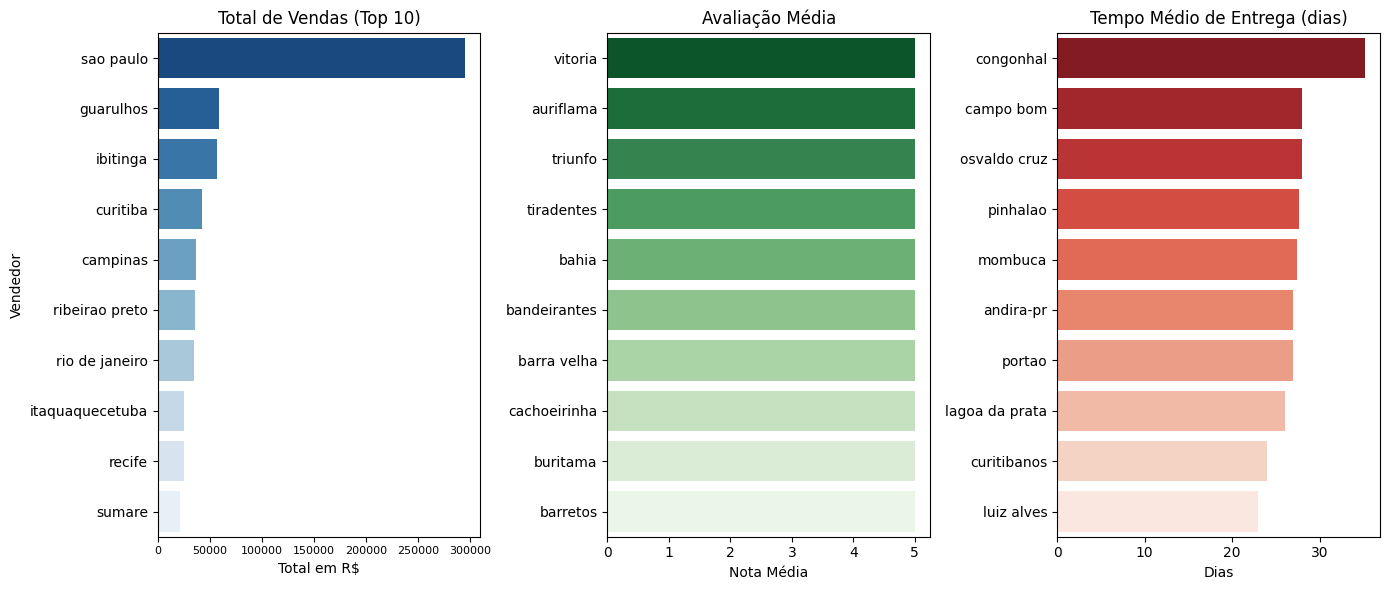

In [ ]:
# Unir dados
df = order_items.merge(orders, on="order_id") \
                .merge(order_reviews, on="order_id") \
                .merge(sellers, on="seller_id")

# Calcular tempo de entrega
df["tempo_entrega_dias"] = (df["order_delivered_customer_date"] - df["order_approved_at"]).dt.days

# Agrupar dados por vendedor
desempenho_vendedores = df.groupby("seller_city").agg(
    total_vendas=("price", "sum"),
    qtd_pedidos=("order_id", "nunique"),
    avaliacao_media=("review_score", "mean"),
    tempo_entrega_medio=("tempo_entrega_dias", "mean")
).reset_index()

# Filtrar os top 10 vendedores por total de vendas
top_vendedores = desempenho_vendedores.sort_values("total_vendas", ascending=False).head(10)
top_vendedores_avaliacao = desempenho_vendedores.sort_values("avaliacao_media", ascending=False).head(10)
top_vendedores_tempo_entrega = desempenho_vendedores.sort_values("tempo_entrega_medio", ascending=False).head(10)

plt.figure(figsize=(14, 6))

# Gráfico 1 - Total de vendas
plt.subplot(1, 3, 1)
sns.barplot(data=top_vendedores, y="seller_city", x="total_vendas", palette="Blues_r")
plt.title("Total de Vendas (Top 10)")
plt.xlabel("Total em R$")
plt.xticks(fontsize=8)
plt.ylabel("Vendedor")

# Gráfico 2 - Avaliação média
plt.subplot(1, 3, 2)
sns.barplot(data=top_vendedores_avaliacao, y="seller_city", x="avaliacao_media", palette="Greens_r")
plt.title("Avaliação Média")
plt.xlabel("Nota Média")
plt.ylabel("")

# Gráfico 3 - Tempo de entrega
plt.subplot(1, 3, 3)
sns.barplot(data=top_vendedores_tempo_entrega, y="seller_city", x="tempo_entrega_medio", palette="Reds_r")
plt.title("Tempo Médio de Entrega (dias)")
plt.xlabel("Dias")
plt.ylabel("")

plt.tight_layout()
plt.show()